# Exploratory Data Analysis for Raw vs. LDA-Processed Data

In this notebook, the following tasks are performed:

Compare raw Reddit data with LDA-ready data.
Load two JSON files and extract documents for analysis.
Generate exploratory plots, including:
Document-length distributions
Top tokens and bigrams
Word clouds
Vocabulary growth metrics
Save all generated visuals to a local folder.
These steps help validate whether the LDA preprocessing has impacted the dataset in meaningful ways and guide subsequent modelling decisions.

## Key Libraries

- **[matplotlib](https://matplotlib.org/)**  
  A comprehensive library for creating static, animated, and interactive visualisations in Python.

- **[NumPy](https://numpy.org/)**  
  The fundamental package for scientific computing in Python, providing high-performance array operations and an extensive collection of mathematical functions.

- **[wordcloud](https://github.com/amueller/word_cloud)**  
  A library for generating word cloud images that visualise text prominence based on frequency.

- **[NLTK (Natural Language Toolkit)](https://www.nltk.org/)**  
  A toolkit offering various utilities for text processing, such as tokenisation, part-of-speech tagging, and more advanced NLP functionalities.

In [1]:
# Core data manipulation and analysis libraries
import json
from pathlib import Path
from collections import Counter
import statistics

# Visualisation libraries
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

# Text processing libraries
import string
import re
import nltk
from nltk import pos_tag

# System and data structure libraries
import os
import pandas as pd

print("Libraries imported successfully.")

Libraries imported successfully.


## Helper Functions

These functions handle data loading, document extraction, and various plotting routines. They are used to compare raw versus processed data, providing essential insights through exploratory visualisations such as document-length distributions, top tokens, bigrams, word clouds, and vocabulary growth curves.

In [6]:
def load_data(file_path):
    """
    Loads and parses JSON data from a file.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def extract_docs_raw(data):
    """
    Extracts raw text from 'title', 'selftext', and 'comments' fields.
    Combines 'title' + 'selftext' for each post, and also adds each comment.
    """
    all_docs = []
    for post in data:
        title = post.get('title', '')
        selftext = post.get('selftext', '')
        main_text = f"{title} {selftext}".strip()
        if main_text:
            all_docs.append(main_text)
        for c in post.get('comments', []):
            c_text = c.get('comment', '').strip()
            if c_text:
                all_docs.append(c_text)
    return all_docs


def extract_docs_processed(data):
    """
    Extracts processed text from 'combined_processed' 
    and each comment's 'comment_processed' field.
    """
    all_docs = []
    for post in data:
        combined_proc = post.get('combined_processed', '').strip()
        if combined_proc:
            all_docs.append(combined_proc)
        for c in post.get('comments', []):
            c_text = c.get('comment_processed', '').strip()
            if c_text:
                all_docs.append(c_text)
    return all_docs


def side_by_side_length_distributions(raw_lengths, processed_lengths):
    """
    Creates a comparative visualisation of document length distributions.
    """
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Left plot: Raw data distribution
    axes[0].hist(raw_lengths, bins=50, color='skyblue', edgecolor='black')
    axes[0].set_title("Raw Data Length Distribution")
    axes[0].set_xlabel("Tokens per Document")
    axes[0].set_ylabel("Frequency")

    # Right plot: Processed data distribution
    axes[1].hist(processed_lengths, bins=50, color='lightgreen', edgecolor='black')
    axes[1].set_title("Processed Data Length Distribution")
    axes[1].set_xlabel("Tokens per Document")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


def display_top_tokens_dataframe(raw_counts, processed_counts, top_n=20):
    """
    Displays two sets of top tokens side by side in a pandas DataFrame.
    """
    top_tokens_raw = raw_counts.most_common(top_n)
    top_tokens_processed = processed_counts.most_common(top_n)

    df_raw = pd.DataFrame(top_tokens_raw, columns=["Raw_Token", "Raw_Freq"])
    df_processed = pd.DataFrame(top_tokens_processed, columns=["Processed_Token", "Processed_Freq"])
    
    # Merge them side by side
    df_combined = pd.concat([df_raw, df_processed], axis=1)
    
    print(f"\nTop {top_n} Tokens: Raw vs. Processed")
    display(df_combined)


def compare_wordclouds(raw_counts, processed_counts):
    """
    Generates two word clouds side by side for raw vs. processed data.
    """
    freq_raw = dict(raw_counts)
    freq_proc = dict(processed_counts)

    wc_raw = WordCloud(width=600, height=400, background_color='white')
    wc_raw.generate_from_frequencies(freq_raw)

    wc_proc = WordCloud(width=600, height=400, background_color='white')
    wc_proc.generate_from_frequencies(freq_proc)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(wc_raw, interpolation='bilinear')
    axes[0].set_title("Raw Data Word Cloud")
    axes[0].axis('off')

    axes[1].imshow(wc_proc, interpolation='bilinear')
    axes[1].set_title("LDA Data Word Cloud")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


def top_bigrams(tokenised_docs):
    """
    Returns a Counter of bigrams from the tokenised documents.
    """
    bigram_counts = Counter()
    for tokens in tokenised_docs:
        for i in range(len(tokens) - 1):
            bigram = (tokens[i], tokens[i+1])
            bigram_counts[bigram] += 1
    return bigram_counts


def side_by_side_bigrams(raw_bigram_counts, proc_bigram_counts, top_n=20):
    """
    Plots two bar charts side by side for the top_n bigrams
    (Raw Data vs. Processed Data).
    """
    raw_top = raw_bigram_counts.most_common(top_n)
    proc_top = proc_bigram_counts.most_common(top_n)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Left subplot: Raw data bigrams
    if raw_top:
        bigrams, freqs = zip(*raw_top)
        labels = [f"{w1}_{w2}" for (w1, w2) in bigrams]

        # Use numeric positions for the x-axis
        x_positions = range(len(labels))
        axes[0].bar(x_positions, freqs, color='purple', edgecolor='black')
        axes[0].set_title("Top Bigrams (Raw Data)")

        # Set the tick positions and labels explicitly
        axes[0].set_xticks(x_positions)
        axes[0].set_xticklabels(labels, rotation=45, ha='right')
    else:
        axes[0].text(0.5, 0.5, "No bigrams found for Raw Data",
                     ha='center', va='center', fontsize=12)

    # Right subplot: Processed daa bigrams
    if proc_top:
        bigrams, freqs = zip(*proc_top)
        labels = [f"{w1}_{w2}" for (w1, w2) in bigrams]

        # Use numeric positions for the x-axis
        x_positions = range(len(labels))
        axes[1].bar(x_positions, freqs, color='purple', edgecolor='black')
        axes[1].set_title("Top Bigrams (Processed Data)")

        # Set the tick positions andlabels explicitly
        axes[1].set_xticks(x_positions)
        axes[1].set_xticklabels(labels, rotation=45, ha='right')
    else:
        axes[1].text(0.5, 0.5, "No bigrams found for Processed Data",
                     ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()


def side_by_side_vocab_growth(raw_docs, processed_docs):
    """
    Plots two vocabulary growth curves side by side: Raw vs. Processed.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Raw data
    raw_unique = set()
    raw_x, raw_y = [], []
    token_count = 0
    for doc in raw_docs:
        tokens = doc.split()
        for t in tokens:
            token_count += 1
            raw_unique.add(t)
            raw_x.append(token_count)
            raw_y.append(len(raw_unique))
    axes[0].plot(raw_x, raw_y, color='blue')
    axes[0].set_title("Vocabulary Growth (Raw Data)")
    axes[0].set_xlabel("Tokens Seen")
    axes[0].set_ylabel("Vocab Size")

    # Processed data
    proc_unique = set()
    proc_x, proc_y = [], []
    token_count = 0
    for doc in processed_docs:
        tokens = doc.split()
        for t in tokens:
            token_count += 1
            proc_unique.add(t)
            proc_x.append(token_count)
            proc_y.append(len(proc_unique))
    axes[1].plot(proc_x, proc_y, color='green')
    axes[1].set_title("Vocabulary Growth (Processed Data)")
    axes[1].set_xlabel("Tokens Seen")
    axes[1].set_ylabel("Vocab Size")

    plt.tight_layout()
    plt.show()

## Main Comparison Function

In this section, the following steps are performed:

Load two datasets:

aggregated_raw_reddit_data.json (raw)
lda_ready_data.json (processed)

Perform exploratory data analysis (EDA) by computing:
Document length statistics (mean, median, min, max)
Most frequent tokens
Rare words

Plot:
Bigrams
Document length distributions
Top tokens
Word clouds
Vocabulary growth curves
These insights illustrate how the raw data differs from the LDA-processed data in terms of text structure and distribution.

,Metric,Raw,Processed
0,Average,135.27,51.98
1,Median,91,35
2,Min,1,2
3,Max,1645,482


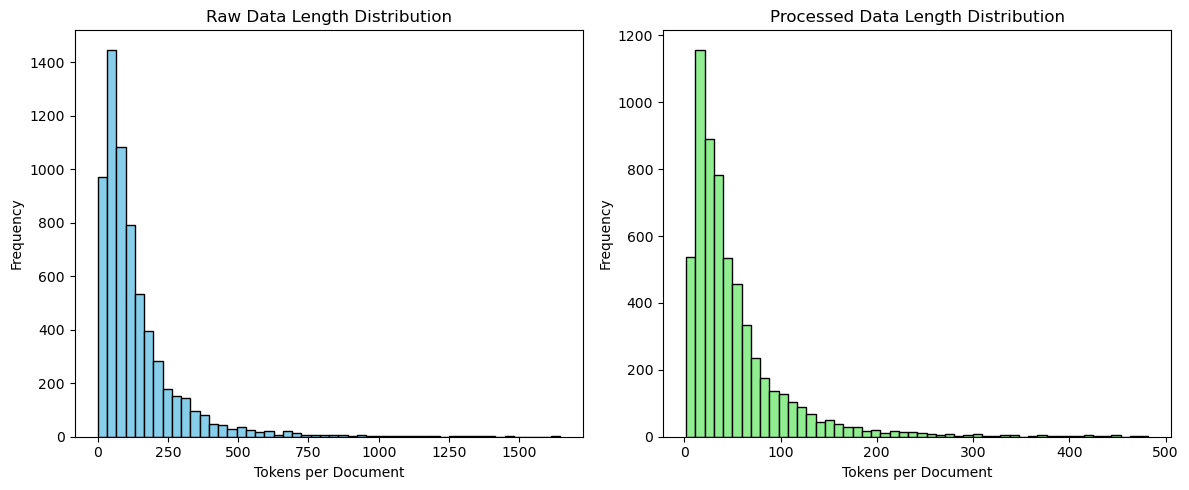


Raw Vocab Size: 48625
Processed Vocab Size: 15499

Top 20 Tokens: Raw vs. Processed


,Raw_Token,Raw_Freq,Processed_Token,Processed_Freq
0,to,27055,diagnosis,4269
1,I,26594,aba,3801
2,and,24369,therapy,3182
3,the,21443,think,2268
4,a,18949,therapist,2107
5,of,14333,need,2079
6,that,12372,adhd,1965
7,is,10752,feel,1910
8,in,9722,help,1881
9,for,9469,way,1750



Number of rare words (raw): 28489
Number of rare words (processed): 5886


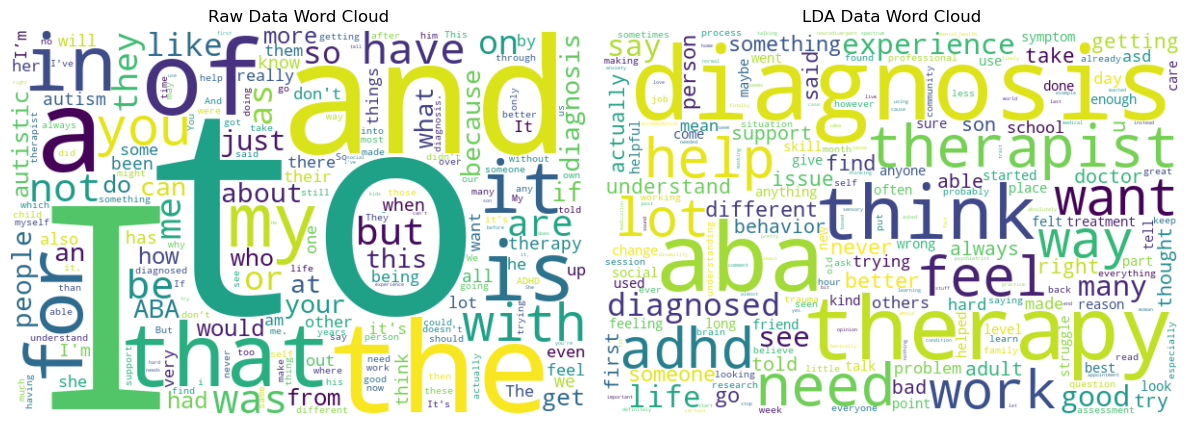

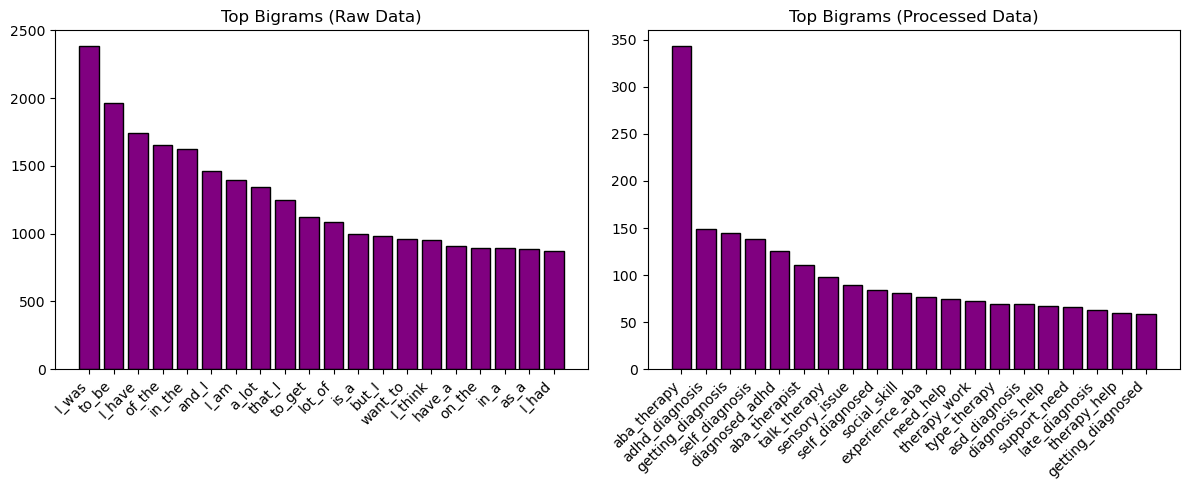

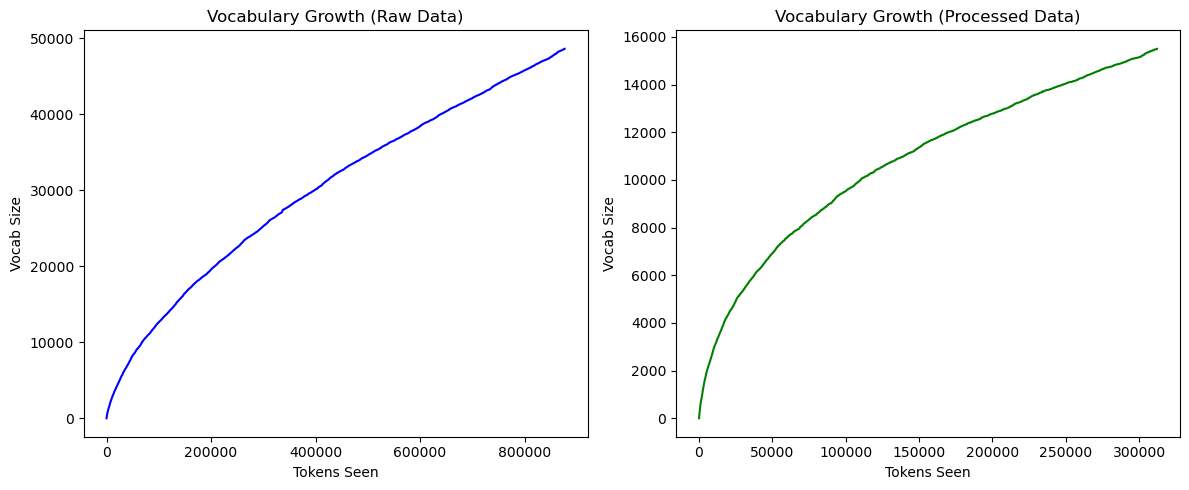

In [7]:
def main():
    """
    Main execution function that orchestrates the EDA process:
    1. Data Loading: Loads both raw and processed Reddit datasets
    2. Text Extraction: Extracts documents from both datasets
    3. Statistical Analysis: Computes document statistics
    4. Visualisation: Generates comparative visualisations
    5. Vocabulary Analysis: Analyses token distributions and patterns
    """
    # File paths configuration
    raw_path = Path(r"C:\Users\laure\Desktop\dissertation_notebook\Data\aggregated_raw_reddit_data.json")
    processed_path = Path(r"C:\Users\laure\Desktop\dissertation_notebook\Data\lda_ready_data.json")

    # Load and process data
    raw_data = load_data(raw_path)
    processed_data = load_data(processed_path)

    # Extract text documents from each dataset
    raw_docs = extract_docs_raw(raw_data)
    processed_docs = extract_docs_processed(processed_data)

    # Tokenise each document (split on whitespace)
    raw_tokenised = [doc.split() for doc in raw_docs if doc.strip()]
    processed_tokenised = [doc.split() for doc in processed_docs if doc.strip()]

    # --------------------------------
    # Document Length Statistics
    # --------------------------------
    
    # Calculate document lengths
    raw_lengths = [len(toks) for toks in raw_tokenised]
    processed_lengths = [len(toks) for toks in processed_tokenised]
    
    # Compute summary stats for raw
    raw_avg = statistics.mean(raw_lengths) if raw_lengths else 0
    raw_median = statistics.median(raw_lengths) if raw_lengths else 0
    raw_min = min(raw_lengths) if raw_lengths else 0
    raw_max = max(raw_lengths) if raw_lengths else 0
    
    # Compute summary stats for processed
    proc_avg = statistics.mean(processed_lengths) if processed_lengths else 0
    proc_median = statistics.median(processed_lengths) if processed_lengths else 0
    proc_min = min(processed_lengths) if processed_lengths else 0
    proc_max = max(processed_lengths) if processed_lengths else 0
    
    # Build a small dictionary containing the metrics
    stats_dict = {
        'Metric':    ['Average', 'Median', 'Min', 'Max'],
        'Raw':       [f"{raw_avg:.2f}", raw_median, raw_min, raw_max],
        'Processed': [f"{proc_avg:.2f}", proc_median, proc_min, proc_max]
    }
    
    # Convert it to a pandas DataFrame
    df_stats = pd.DataFrame(stats_dict)
    
    # Display the DataFrame as a table
    display(df_stats)

    # --------------------------------
    # Side-by-Side Distribution Plots
    # --------------------------------
    side_by_side_length_distributions(raw_lengths, processed_lengths)

    # --------------------------------
    # Token Frequency & Vocabulary
    # --------------------------------
    raw_all_tokens = [t for doc in raw_tokenised for t in doc]
    processed_all_tokens = [t for doc in processed_tokenised for t in doc]

    raw_counts = Counter(raw_all_tokens)
    processed_counts = Counter(processed_all_tokens)

    print(f"\nRaw Vocab Size: {len(set(raw_all_tokens))}")
    print(f"Processed Vocab Size: {len(set(processed_all_tokens))}")

    # Display top tokens side by side as a table
    display_top_tokens_dataframe(raw_counts, processed_counts, top_n=20)

    # Identify rare (hapax) words
    raw_rare = [w for w, c in raw_counts.items() if c == 1]
    proc_rare = [w for w, c in processed_counts.items() if c == 1]
    print(f"\nNumber of rare words (raw): {len(raw_rare)}")
    print(f"Number of rare words (processed): {len(proc_rare)}")

    # --------------------------------
    # Side-by-Side Word Clouds
    # --------------------------------
    compare_wordclouds(raw_counts, processed_counts)

    # --------------------------------
    # Bigrams Comparison
    # --------------------------------
    raw_bigram_counts = top_bigrams(raw_tokenised)
    processed_bigram_counts = top_bigrams(processed_tokenised)
    side_by_side_bigrams(raw_bigram_counts, processed_bigram_counts, top_n=20)

    # --------------------------------
    # Vocabulary Growth Curves
    # --------------------------------
    side_by_side_vocab_growth(raw_docs, processed_docs)


# 4. ENTRY POINT
if __name__ == "__main__":
    main()

## References

**Reference:**  
PRAW Development Team (2024) *PRAW: Python Reddit API Wrapper v7.8.1* [computer program].  
Available from: [https://praw.readthedocs.io/en/stable/](https://praw.readthedocs.io/en/stable/) [Accessed 20 May 2024].

**Git Repo:**  
- [PRAW GitHub](https://github.com/praw-dev/praw)

**Reference:**  
Harris, C. R., Millman, K. J., van der Walt, S. J., et al. (2020) *Array programming with NumPy* [computer program]. *Nature*, 585, pp. 357–362 (v1.24.4).  
Available from: [https://numpy.org/](https://numpy.org/) [Accessed 20 May 2024].

**Git Repo:**  
- [NumPy GitHub](https://github.com/numpy/numpy)

**Reference:**  
Pandas Development Team (2024) *pandas: Powerful data structures for data analysis v2.2.3* [computer program].  
Available from: [https://pandas.pydata.org/](https://pandas.pydata.org/) [Accessed 20 May 2024].

**Git Repo:**  
- [Pandas GitHub](https://github.com/pandas-dev/pandas)

**Reference:**  
Hunter, J. D. (2007) *Matplotlib: A 2D Graphics Environment* [computer program]. *Computing in Science & Engineering*, 9(3), pp. 90–95 (v3.7.3).  
Available from: [https://matplotlib.org/](https://matplotlib.org/) [Accessed 20 May 2024.

**Git Repo:**  
- [Matplotlib GitHub](https://github.com/matplotlib/matplotlib)

**Reference:**  
Waskom, M. (2024) *seaborn: Statistical data visualization v0.13.2* [computer program].  
Available from: [https://joss.theoj.org/papers/10.21105/joss.03021](https://joss.theoj.org/papers/10.21105/joss.03021) [Accessed 20 May 2024].

**Git Repo:**  
- [Seaborn GitHub](https://github.com/mwaskom/seaborn)

**Reference:**  
Bird, S., Klein, E., and Loper, E. (2009) *Natural Language Processing with Python*. O'Reilly Media Inc.  
Available from: [https://www.nltk.org/](https://www.nltk.org/) [Accessed 20 May 2024].

**Git Repo:**  
- [NLTK GitHub](https://github.com/nltk/nltk)

**Reference:**  
Řehůřek, R., and Sojka, P. (2010) *Software Framework for Topic Modelling with Large Corpora*. In *Proceedings of the LREC 2010 Workshop on New Challenges for NLP Frameworks*.  
Available from: [https://radimrehurek.com/gensim/](https://radimrehurek.com/gensim/) [Accessed 20 May 2024].

**Git Repo:**  
- [Gensim GitHub](https://github.com/RaRe-Technologies/gensim)


**Reference:**  
Ray, R. (2024) *Wordcloud: A little word cloud generator v1.9.2* [computer program].  
Available from: [https://github.com/amueller/word_cloud](https://github.com/amueller/word_cloud) [Accessed 20 May 2024].

**Git Repo:**  
- [Wordcloud GitHub](https://github.com/amueller/word_cloud)